In [1]:
import torch
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import gseapy as gp
from scipy.stats import pearsonr, zscore
import anndata
from statsmodels.stats import multitest
import anndata as ad

In [2]:
#Data reading and preprocessing
vis=sc.read_10x_h5("./VisiumFFPE_Mouse_Brain_Alzheimers_AppNote_filtered_feature_bc_matrix.h5")
vis.X=vis.X.toarray()
labels=pd.read_csv("./labels_alz_afterbatch.csv", index_col=0)
labels['clusters']=labels['clusters'].replace({8 : 3})
labels['condition'] = np.where(labels['batch'].isin([1,2,3,4,5,6]), 1, 0)
labels['time'] = np.where(
    labels['batch'].isin([1, 2, 7, 8]), 2,
    np.where(
        labels['batch'].isin([3, 4, 9, 10]), 0,
        1
    )
)

labels["batch_cluster"]=labels["batch"].astype(str) + "-" + labels["clusters"].astype(str)#.values.astype(str)[x]

batches=np.unique(labels.batch_cluster)
vis.obs=pd.merge(vis.obs, labels, left_index=True, right_index=True)
ls=[]
for i in batches:
    sub=vis[vis.obs.batch_cluster == i]
    colsum=sub.X.sum(axis=0)
    ls.append(colsum)

metadata = labels
metadata=metadata.reset_index()
metadata=metadata.drop("index", axis=1)
metadata=metadata.set_index("batch_cluster")
metadata=metadata.drop_duplicates()

# class_map = {0: 'GABA', 1: 'L6b', 2: 'L5/6 NP', 3: 'L2/3 IT', 4: 'OPC', 5:'Immune/Vasc', 6:'Oligo', 7:'L6 IT Car3', 8: 'L2/3 IT'}
# metadata["clusters"] = metadata.clusters.replace(class_map)

vis.var_names_make_unique()
## split for review

vis = vis[vis.obs_names.str.endswith(('-2', '-4', '-6', '-8', '-10', '-12'))]
TF_pseudobulk=pd.DataFrame(np.array(ls).T, index=vis.var_names, columns=batches)
TG_pseudobulk=np.log(1 + ((TF_pseudobulk * 1e+6) / TF_pseudobulk.sum() ))

/home/idebnat/.conda/envs/ish_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# LINGER dir
Datadir="./data_new/"

In [6]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import quantile_transform
from sklearn.decomposition import NMF
print('loading GRN......')
trans_reg=pd.read_csv(Datadir+'cell_population_trans_regulatory.txt',sep='\t',index_col=0)
TG_pseudobulk=TG_pseudobulk.drop_duplicates()
column_sums=TG_pseudobulk.T.sum()
gene_keep=TG_pseudobulk.index
trans_reg=trans_reg[trans_reg.index.isin(gene_keep)]
TFset=trans_reg.columns
TGset=trans_reg.index
celltype = metadata['clusters'].unique()
R1 = stats.zscore(trans_reg,1);R1[np.isnan(R1)] = 0.0
R2 = stats.zscore(trans_reg,0);R2[np.isnan(R2)] = 0.0
Exp=pd.DataFrame(TG_pseudobulk,index=TG_pseudobulk.index,columns=TG_pseudobulk.columns)
Z=R1+R2
Z[Z<0]=0  

loading GRN......


## Calculating fold change for different scenarios

In [8]:

cluster_fc = pd.DataFrame(index = TG_pseudobulk.index)
for c in np.unique(metadata.clusters):
    cluster_average = pd.DataFrame(index = TG_pseudobulk.index)
    cluster_average['trans_old']=TG_pseudobulk[metadata[(metadata.clusters == c) & (metadata.condition == 1) & (metadata.time == 2)].index].mean(axis=1)
    cluster_average['trans_young']=TG_pseudobulk[metadata[(metadata.clusters == c) & (metadata.condition == 1) & (metadata.time == 0)].index].mean(axis=1)
    cluster_average['wild_old']=TG_pseudobulk[metadata[(metadata.clusters == c) & (metadata.condition == 0) & (metadata.time == 2)].index].mean(axis=1)
    cluster_average['wild_young']=TG_pseudobulk[metadata[(metadata.clusters == c) & (metadata.condition == 0) & (metadata.time == 0)].index].mean(axis=1)
    cluster_fc[f"FC_int_{c}"]=(cluster_average['trans_old'] - cluster_average['trans_young']) - (cluster_average['wild_old'] - cluster_average['wild_young'])  
    cluster_fc[f"FC_trans_time_{c}"]=cluster_average['trans_old'] - cluster_average['trans_young']
    cluster_fc[f"FC_wild_time_{c}"]=cluster_average['wild_old'] - cluster_average['wild_young']
    cluster_fc[f"FC_cond_old_{c}"]=cluster_average['trans_old'] - cluster_average['wild_old']


In [9]:
#cluster_fc=pd.read_csv("FC_cell_labels.csv", index_col=0)

In [10]:
umap_ad=anndata.AnnData(Z)

df_obsm = cluster_fc.loc[umap_ad.obs_names]
umap_ad.obsm['FC_net'] = df_obsm.values

/home/idebnat/.conda/envs/ish_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
# umap_ad.X = scaler.fit_transform(umap_ad.X)

kmeans = KMeans(n_clusters=12, random_state=42)
cluster_labels = kmeans.fit_predict(umap_ad.X)

umap_ad.obs["modules"]=cluster_labels

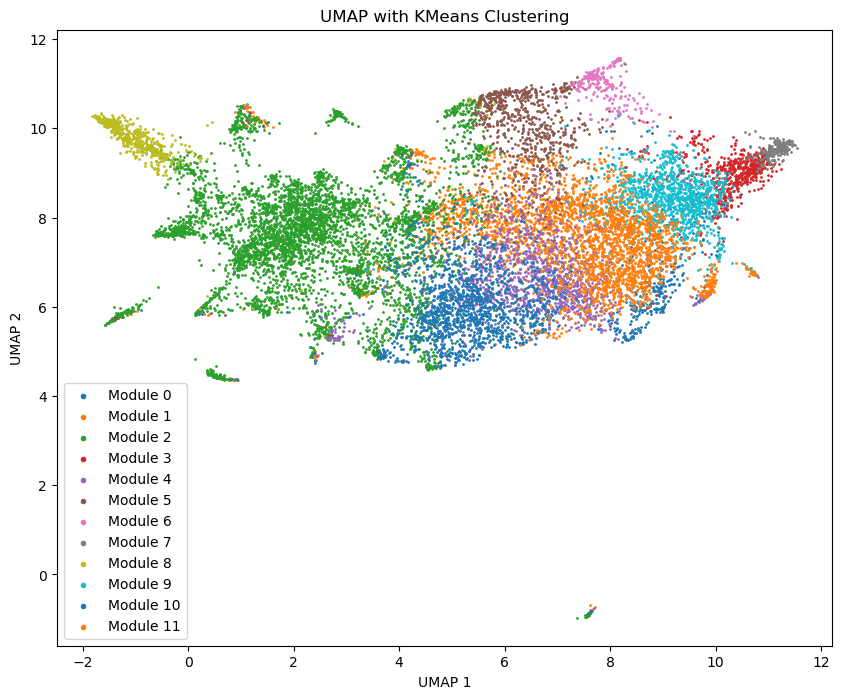

In [13]:
import umap

reducer = umap.UMAP(min_dist=0.1, random_state=42, n_neighbors=30)
embedding = reducer.fit_transform(umap_ad.X)
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(10, 8))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(
        embedding[idx, 0],
        embedding[idx, 1],
        s=1,
        label=f'Module {label}'
    )

plt.legend(markerscale=3)
plt.title("UMAP with KMeans Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
#plt.savefig("umap_modules.pdf", format='pdf', dpi=300)
plt.show()

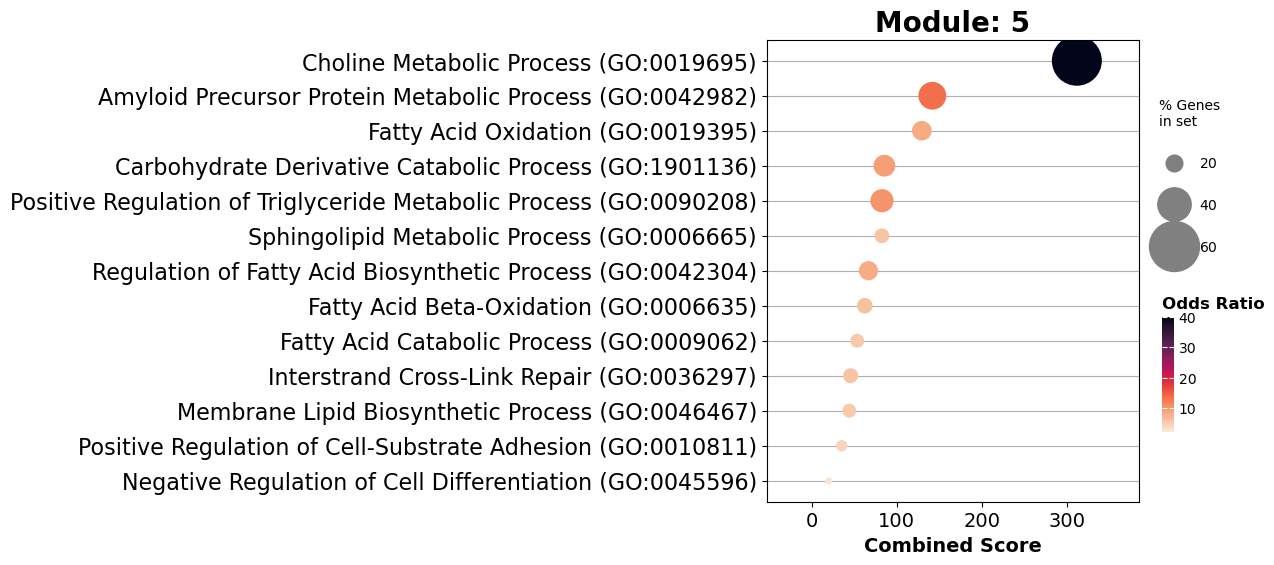

In [14]:
mo=5
gene_list = umap_ad[umap_ad.obs['modules']== mo].obs.index.to_list()
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=[ 'GO_Biological_Process_2025'],
                 outdir=None)

ax = gp.dotplot(enr.res2d[enr.res2d['Adjusted P-value']<0.1], column="Odds Ratio", size = 10,cmap='rocket_r',title=f'Module: {mo}', cutoff=0.1, top_term=15, figsize=(6, 6))

## spatial pattern of modules

In [16]:

umap_ad.obs['modules'] = umap_ad.obs['modules'].astype(str)

In [17]:

def plot_module_adata(filepath, sample, ls):
    vis_data=sc.read_visium(filepath)
    vis_data.X=vis_data.X.toarray()
    vis_data=vis_data[:,vis_data.X.sum(axis=0) > 0]
    
    mean = vis_data.X.copy().mean(axis=0)
    std = vis_data.X.copy().std(axis=0)
    vis_data.X = (vis_data.X.copy() - mean) / std
    
    adatas=[]
    for i in ls:
        gs=vis_data[:,vis_data.var_names.isin(umap_ad[umap_ad.obs['modules']== i].obs.index.to_list())].copy()
        gs.var["Module"] = np.repeat(i, repeats=gs.shape[1])
        adatas.append(gs)
        
    adata=ad.concat(adatas, axis=1, join='outer')
    adata=adata[adata.obs_names.str.endswith(sample)]
    vis_data=vis_data[vis_data.obs_names.str.endswith(sample)]
    vis_data.obs=vis_data.obs.merge(labels[["clusters"]], left_index=True, right_index=True)
    
    groups = adata.var["Module"].unique()

    reduced = []

    for group in groups:

        X_sub = adata[:, adata.var["Module"] == group].X
        if not isinstance(X_sub, np.ndarray):
            X_sub = X_sub.toarray()
        group_mean = X_sub.mean(axis=1)
        reduced.append(group_mean)

    # Stack results: shape (n_cells, n_groups)
    X_reduced = np.vstack(reduced).T
    
    adata_reduced = ad.AnnData(X=X_reduced)
    adata_reduced.obs = vis_data.obs.copy()
    adata_reduced.obsm = vis_data.obsm.copy()
    adata_reduced.uns = vis_data.uns.copy()
    adata_reduced.var = pd.DataFrame(index=groups)
    
    adata_reduced.obs.clusters=adata_reduced.obs.clusters.astype(str)
    
    return adata_reduced

In [19]:
ls=["5"]
adata_wt13p=plot_module_adata("/project/zduren/durenlab/idebnat/palmetto/Mousebrain/rename_files/spatial/Wildtype_13p4_rep2/", "-8", ls=ls)
adata_tr17p=plot_module_adata("/project/zduren/durenlab/idebnat/palmetto/Mousebrain/rename_files/spatial/Transgenic_17p9_rep2/", "-2", ls=ls)
adata_tr2p=plot_module_adata("/project/zduren/durenlab/idebnat/palmetto/Mousebrain/rename_files/spatial/Transgenic_2p5_rep2/", "-4", ls=ls)
adata_wt2p=plot_module_adata("/project/zduren/durenlab/idebnat/palmetto/Mousebrain/rename_files/spatial/Wildtype_2p5_rep2/", "-10", ls=ls)


/home/idebnat/.conda/envs/ish_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


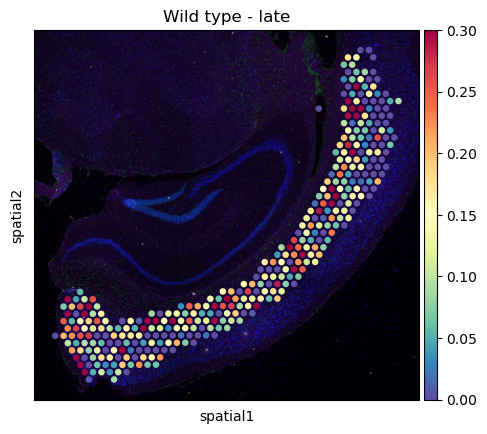

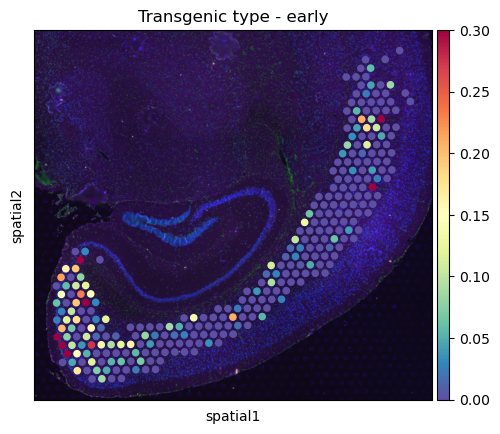

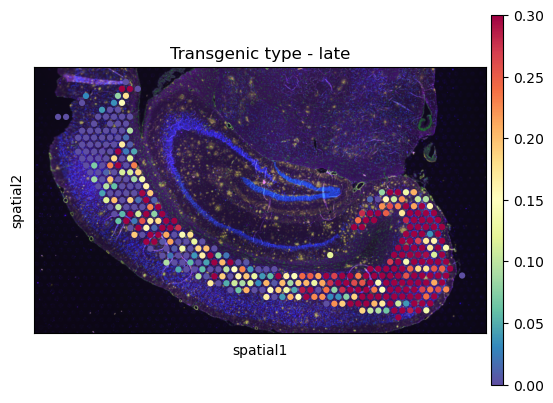

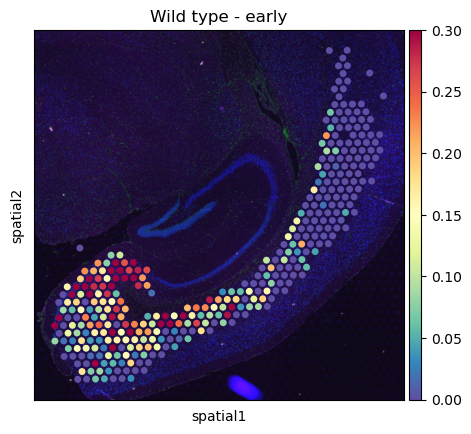

In [21]:
sc.pl.spatial(adata_wt13p[adata_wt13p.obs.clusters == "2"], color="5", size=1.2, ncols=3, cmap="Spectral_r", vmin=0, vmax=0.3, title="Wild type - late")#, save="Wt13p-c2m5_even.pdf") #7
sc.pl.spatial(adata_tr2p[adata_tr2p.obs.clusters == "2"], title="Transgenic type - early", color="5", size=1.2, ncols=3, cmap="Spectral_r", vmin=0, vmax=0.3) # , save="Tr2p-c2m5_even.pdf") #3
sc.pl.spatial(adata_tr17p[adata_tr17p.obs.clusters == "2"], title="Transgenic type - late", color="5", size=1.2, ncols=3, cmap="Spectral_r", vmin=0, vmax=0.3) #, save="Tr17p-c2m5_even.pdf") #1
sc.pl.spatial(adata_wt2p[adata_wt2p.obs.clusters == "2"], title="Wild type - early", color="5", size=1.2, ncols=3, cmap="Spectral_r", vmin=0, vmax=0.3) #, save="Wt2p-c2m5_even.pdf") #1